In [14]:
from os import listdir, path, mkdir
from datetime import datetime
import requests
import shutil
import matplotlib.pyplot as plt # Import the Matplotlib package
from osgeo import gdal # Import the GDAL library
from pprint import pprint
import numpy as np

In [2]:
# Load the data from NOAA website, if needed
if not path.exists("gfs_data/") or len([f for f in listdir("gfs_data/") if not f.startswith('.')]) == 0:
    files_to_download = []
    today = datetime.today()

    # Download the GFS data from the past 1 month (there's roughly 1 year of data online, each month is ~1GB)
    month_str = "0" + str(today.month - 1) if len(str(today.month - 1)) == 1 else str(today.month - 1)
    month_string = str(today.year) + month_str

    for day in range(1,29):
        for suffix in [".grb2", ".inv"]:
            day_str = "0" + str(day) if len(str(day)) == 1 else str(day)
            date_string = month_string + day_str
            data_file_name = "gfs_3_" + month_string + day_str + "_0000_000" + suffix
            files_to_download.append((date_string, data_file_name))
            r = requests.get("https://nomads.ncdc.noaa.gov/data/gfs-avn-hi/"+ month_string + "/" + date_string
                         + "/" + data_file_name, stream=True)
            if not path.exists("gfs_data/"):
                mkdir("gfs_data/")
            with open("gfs_data/" + data_file_name, 'wb') as fin:
                shutil.copyfileobj(r.raw, fin)
                fin.close()    
    
    print("success")

In [3]:
# The data is in GRIB (GRIdded Binary or General Regularly-distributed Information in Binary form)
# Fun fact: NAM uses GRIB second edition (which is distinct from GRIB first edition sub-version 2)
# The .INV files have an "inventory" of the data.
# See https://www.nco.ncep.noaa.gov/pmb/products/gfs/gfs.t00z.pgrb2.0p25.f003.shtml for English explanations of params
file = 'rap_130_20131206_0500_001.grb2' #example filename

grib = gdal.Open('gfs_data/gfs_3_20190701_0000_000.grb2')
print(grib)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1069223c0> >


In [7]:
# What is this? Let's look at the inventory associated with this file
with open('gfs_data/gfs_3_20190701_0000_000.inv', 'r') as myfile:
    data=myfile.read()
    pprint(data)

('1:0:d=2019070100:CLWMR:1 hybrid level:anl:\n'
 '2:5227:d=2019070100:ICMR:1 hybrid level:anl:\n'
 '3:11931:d=2019070100:RWMR:1 hybrid level:anl:\n'
 '4:19915:d=2019070100:SNMR:1 hybrid level:anl:\n'
 '5:21731:d=2019070100:GRLE:1 hybrid level:anl:\n'
 '6:23056:d=2019070100:REFC:entire atmosphere:anl:\n'
 '7:95270:d=2019070100:VIS:surface:anl:\n'
 '8:154804:d=2019070100:UGRD:planetary boundary layer:anl:\n'
 '9:209569:d=2019070100:VGRD:planetary boundary layer:anl:\n'
 '10:265116:d=2019070100:VRATE:planetary boundary layer:anl:\n'
 '11:317387:d=2019070100:GUST:surface:anl:\n'
 '12:372484:d=2019070100:HGT:0.4 mb:anl:\n'
 '13:436531:d=2019070100:TMP:0.4 mb:anl:\n'
 '14:473474:d=2019070100:ABSV:0.4 mb:anl:\n'
 '15:510547:d=2019070100:O3MR:0.4 mb:anl:\n'
 '16:594242:d=2019070100:HGT:1 mb:anl:\n'
 '17:658141:d=2019070100:TMP:1 mb:anl:\n'
 '18:679671:d=2019070100:RH:1 mb:anl:\n'
 '19:679994:d=2019070100:UGRD:1 mb:anl:\n'
 '20:725008:d=2019070100:VGRD:1 mb:anl:\n'
 '21:765178:d=2019070100:O3MR

In [8]:
# Bands 8/9 seem to be U & V components of wind, at the planetary boundary layer
# Bands 19/20 seem to be U & V components of wind, at the 1mb layer (mile below? meter below? probably mile)
# Bands 25/26 seem to be U & V components of wind, at the 2mb layer
# Bands 31/32 seem to be U & V components of wind, at the 3mb layer
# ... continues to loop every so often, with more variables/measurements added as we get closer to sea level
# Bands 197/198 seem to be U & V components of wind, at the 400mb layer
# Bands 305/306 seem to be U & V components of wind, at the 750mb layer
# Bands 396/397 seem to be U & V components of wind, at the 975mb layer
band = grib.GetRasterBand(8)
data = band.ReadAsArray()
print(data)

[[ 0.07564697 -0.02435303 -0.02435303 ...  0.17564698  0.07564697
   0.07564697]
 [-1.424353   -1.52435303 -1.52435303 ... -1.424353   -1.424353
  -1.424353  ]
 [-0.82435304 -0.82435304 -1.02435303 ... -0.82435304 -0.82435304
  -0.82435304]
 ...
 [-5.52435303 -5.52435303 -5.42435312 ... -5.82435322 -5.72435331
  -5.62435293]
 [-5.82435322 -5.82435322 -5.72435331 ... -5.22435331 -5.82435322
  -5.82435322]
 [-2.62435317 -2.52435303 -2.42435312 ... -2.92435312 -2.82435298
  -2.72435308]]


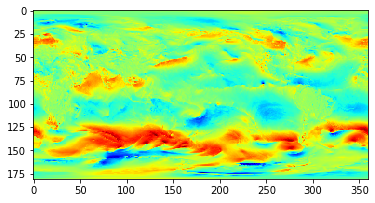

In [9]:
plt.imshow(data, cmap='jet')

In [ ]:
# Get the data and its corresponding latitude and longitude values
from osgeo import osr

src_srs = osr.SpatialReference()
src_srs.ImportFromWkt(grib.GetProjection())
# geomTransform = grib.GetGeoTransform()
tgt_srs = osr.SpatialReference()
tgt_srs.ImportFromEPSG(4326)

transform = osr.CoordinateTransformation(src_srs, tgt_srs)

x_size = grib.RasterXSize
y_size = grib.RasterYSize
u_wind_speeds = grib.GetRasterBand(8)
u_data_array = u_wind_speeds.ReadAsArray()
v_wind_speeds = grib.GetRasterBand(9)
v_data_array = v_wind_speeds.ReadAsArray()
coordinates = []
data_points = []
for row in range(y_size):
    for col in range(x_size):
        u_wind_speed = u_data_array[row][col]
        v_wind_speed = v_data_array[row][col]
        if u_wind_speed != u_wind_speeds.GetNoDataValue() and  v_wind_speed != v_wind_speeds.GetNoDataValue():
            lat_long_point = transform.TransformPoint(row, col)
            lat = lat_long_point[0] - 90
            long = lat_long_point[1] if lat_long_point[1] <= 180 else lat_long_point[1] - 360
            coordinates.append((lat, long))
            data_points.append((u_wind_speed, v_wind_speed))

In [15]:
pprint(np.array(coordinates).shape)
pprint(np.array(data_points).shape)

(65160, 2)
(65160, 2)
